In [61]:
#import required packages
#basics
import pandas as pd 
import numpy as np

#viz
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec 
import seaborn as sns

#misc
import gc
import time
import warnings
import string
import re

#stats
from scipy.misc import imread
from scipy import sparse
import scipy.stats as ss

#nlp
import nltk
from nltk.corpus import stopwords
#import spacy
from nltk import pos_tag
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import word_tokenize

#FeatureEngineering
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import log_loss, confusion_matrix, classification_report, roc_curve, auc

%matplotlib inline

print("modules loaded")

modules loaded


In [59]:
#importing the dataset
train = pd.read_csv("../data/train.csv")
test = pd.read_csv("../data/test.csv")

In [17]:
print("Training set: ", train.shape)
print("Test set: ", test.shape)

train.head()

Training set:  (159571, 8)
Test set:  (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [13]:
test.fillna(' ',inplace=True)
gc.collect()

0

### Text pre-processing

In [ ]:
#https://drive.google.com/file/d/0B1yuv8YaUVlZZ1RzMFJmc1ZsQmM/view
# Aphost lookup dict
APPO = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not",
"tryin'":"trying"
}

In [ ]:
def clean(comment):
    """
    This function receives comments and returns clean word-list
    """
    #Convert to lower case , so that Hi and hi are the same
    comment=comment.lower()
    #remove \n
    comment=re.sub("\\n","",comment)
    # remove leaky elements like ip,user
    comment=re.sub("\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}","",comment)
    #removing usernames
    comment=re.sub("\[\[.*\]","",comment)
    
    #Split the sentences into words
    words=tokenizer.tokenize(comment)
    
    # (')aphostophe  replacement (ie)   you're --> you are  
    # ( basic dictionary lookup : master dictionary present in a hidden block of code)
    words=[APPO[word] if word in APPO else word for word in words]
    words=[lem.lemmatize(word, "v") for word in words]
    words = [w for w in words if not w in eng_stopwords]
    
    clean_sent=" ".join(words)
    # remove any non alphanum,digit character
    #clean_sent=re.sub("\W+"," ",clean_sent)
    #clean_sent=re.sub("  "," ",clean_sent)
    return(clean_sent)

In [18]:
merge=pd.concat([train.iloc[:,0:2],test.iloc[:,0:2]])
df=merge.reset_index(drop=True)

In [19]:
corpus=merge.comment_text
corpus.shape

(312735,)

In [ ]:
start_time=time.time()

clean_corpus=corpus.apply(lambda x :clean(x))

end_time=time.time()
print("total time till Cleaning",end_time-start_time)

In [25]:
start_unigrams=time.time()
tfv = TfidfVectorizer(min_df=200, max_features=10000,
            strip_accents='unicode', analyzer='word',ngram_range=(1,1),
            use_idf=1,smooth_idf=1,sublinear_tf=1,
            stop_words = 'english', dtype=np.float32)

tfv.fit(corpus)
features = np.array(tfv.get_feature_names())
features.shape

In [30]:
train_unigrams =  tfv.transform(corpus.iloc[:train.shape[0]])
test_unigrams = tfv.transform(corpus.iloc[train.shape[0]:])

### Feature selection

In [41]:
y_classes = list(train.columns.values)[2:]
y_classes

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [43]:
y = train[y_classes]
y.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [44]:
x_train = train_unigrams
x_test = test_unigrams

del train_unigrams
del test_unigrams
gc.collect()

267

In [ ]:
## Indirect features

#Sentense count in each comment:
    #  '\n' can be used to count the number of sentences in each comment
df['count_sent']=df["comment_text"].apply(lambda x: len(re.findall("\n",str(x)))+1)
#Word count in each comment:
df['count_word']=df["comment_text"].apply(lambda x: len(str(x).split()))
#Unique word count
df['count_unique_word']=df["comment_text"].apply(lambda x: len(set(str(x).split())))
#Letter count
df['count_letters']=df["comment_text"].apply(lambda x: len(str(x)))
#punctuation count
df["count_punctuations"] =df["comment_text"].apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
#upper case words count
df["count_words_upper"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
#title case words count
df["count_words_title"] = df["comment_text"].apply(lambda x: len([w for w in str(x).split() if w.istitle()]))
#Number of stopwords
df["count_stopwords"] = df["comment_text"].apply(lambda x: len([w for w in str(x).lower().split() if w in eng_stopwords]))
#Average length of the words
df["mean_word_len"] = df["comment_text"].apply(lambda x: np.mean([len(w) for w in str(x).split()]))

#derived features
#Word count percent in each comment:
df['word_unique_percent']=df['count_unique_word']*100/df['count_word']
#derived features
#Punct percent in each comment:
df['punct_percent']=df['count_punctuations']*100/df['count_word']

### Learning

In [52]:
prd = np.zeros((x_test.shape[0],len(y_classes)))
lrs = []

for i,col in enumerate(y_classes):
    print(i,col)
    lr = LogisticRegression(C=10,random_state = i,class_weight = 'balanced')
    lr.fit(x_train, y[col])
    lrs.append(lr)
    prd[:,i] = lr.predict_proba(x_test)[:,1]    

0 toxic
1 severe_toxic
2 obscene
3 threat
4 insult
5 identity_hate


### Validation

In [56]:
col_index = 5
col_name = y_classes[col_index]
print("Column:", col_name)

pred =  lrs[col_index].predict(x_train)
print('\nConfusion matrix\n', confusion_matrix(y[col_name], pred))
print(classification_report(y[col_name], pred))

Column: identity_hate

Confusion matrix
 [[153752   4414]
 [    10   1395]]
             precision    recall  f1-score   support

          0       1.00      0.97      0.99    158166
          1       0.24      0.99      0.39      1405

avg / total       0.99      0.97      0.98    159571



Column: identity_hate


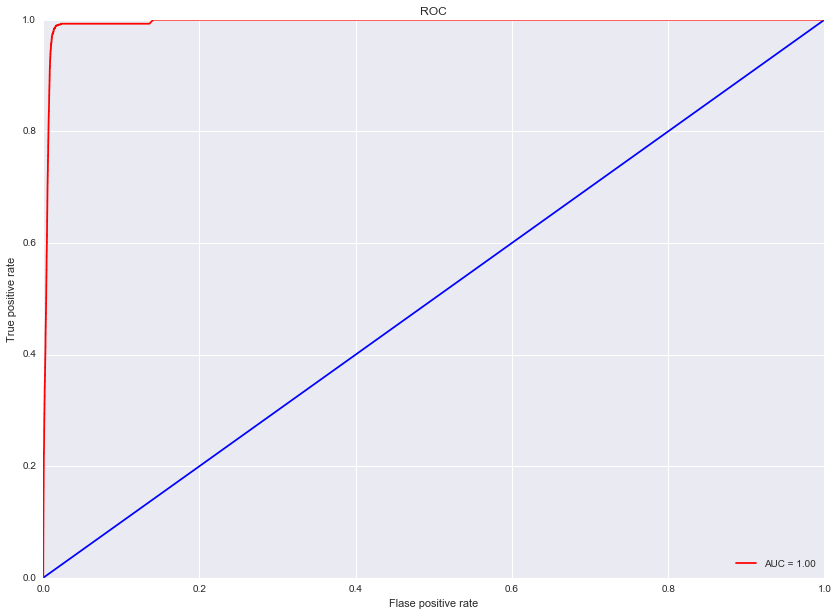

In [72]:
col_index = 5
col_name = y_classes[col_index]
print("Column:",col)

pred_pro = lrs[col_index].predict_proba(x_train)[:,1]
fpr, tpr, thresh = roc_curve(y[col_name], pred_pro)
auc_val = auc(fpr, tpr)

plt.figure(figsize=(14,10))
plt.plot([0,1], [0,1], color='b')
plt.plot(fpr, tpr, color='r', label= 'AUC = %.2f'%auc_val)
plt.legend(loc='lower right')
plt.xlabel('Flase positive rate')
plt.ylabel('True positive rate')
plt.title('ROC')

### Submission

In [64]:
prd_1 = pd.DataFrame(prd, columns=y_classes)
submit = pd.concat([test['id'], prd_1],axis=1)
submit.to_csv('../submissions/toxic_lr.csv', index=False)
submit.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.999999,0.983599,1.000000,0.527743,0.999890,0.996529
1,0000247867823ef7,0.005812,0.000498,0.000034,0.000108,0.010595,0.000799
2,00013b17ad220c46,0.033889,0.000106,0.018914,0.000003,0.060814,0.027470
3,00017563c3f7919a,0.005304,0.005686,0.001637,0.000011,0.002474,0.000077
4,00017695ad8997eb,0.171888,0.023795,0.017781,0.000646,0.043282,0.000895
